<a href="https://colab.research.google.com/github/francobarrionuevoenv21/PaddyFieldStaFe_Segm_UNETs_public/blob/main/BestUNET_preds_evalV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

### About the Project

The project consists of training a Convolutional Neural Network to detect active/in-production paddy fields in a region in northern Santa Fe, Argentina. This area was originally characterized by wetlands, but in recent decades these natural ecosystems have been converted into paddy fields.

The approach will involve training a basic [U-Net neural network](https://www.geeksforgeeks.org/machine-learning/u-net-architecture-explained/) along with two variations. These variations will use different backbones and pretrained weights.

### Notebook Description

The best UNET trained model (UNET + SEResNet 34) predictions are evaluated by comparing the results with validated data. Additionally, are assesed the predictions for years in which there were no previously data: 2023, 2024, 2025. According to the obtained results, are proposed strategies to improve them in future stages.

# Code Development

In [67]:
## INSTALL DEPENDENCIES AND IMPORT LIBRARIES

import os

import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

## Data importing and processing

In [ ]:
# LOAD VALIDATED DATA AND PREDICTIONS

In [5]:
# UNZIP FOLDER WITH PREDICTIONS

# Set file path and create the output foleder

##  L8 scenes
zip_file_path_01 = '/content/Predicts.zip'
destination_folder_01 = '/content/predicts_vectorized'
os.makedirs(destination_folder_01, exist_ok=True) # Create the destination folder if it doesn't exist

# Unzip the compressed files in the destionation folder
!unzip -q {zip_file_path_01} -d {destination_folder_01}

In [ ]:
# LOAD VECTOR FILE WITH VALIDATED DATA

# Define a crs in meters
targetCRS_meters = "EPSG:5343" # POSGAR 2007 / Argentina 1 (EPSG:5343)
gdf_val_pf = gpd.read_file('...').to_crs(targetCRS_meters)

In [17]:
# CALCULATE PADDY FIELDS VALIDATED AREA BY YEAR (2018-2022) AND STORE IT IN A LIST FOR PLOTTING

list_pf_ha = []

for y in range(2018, 2023):
  if y == 2022:
    gdf_val_pf_filt = gdf_val_pf[(gdf_val_pf['anio_fin'] == y)].copy()
  else:
    gdf_val_pf_filt = gdf_val_pf[(gdf_val_pf['anio_ini'] <= y) & (gdf_val_pf['anio_fin'] > y)].copy()

  # Make geometries valid before dissolving
  gdf_val_pf_filt['geometry'] = gdf_val_pf_filt.geometry.make_valid()
  gdf_val_pf_diss = gdf_val_pf_filt.dissolve()
  list_pf_ha.append(gdf_val_pf_diss.area/1e4)

In [20]:
# CALCULATE PREDICTED PADDY FIELDS AREA BY YEAR AND STORE IT IN A LIST FOR PLOTTING

list_pfpred_ha = []

list_year_pred = [2018, 2020, 2022, 2023, 2024, 2025]

for y in list_year_pred:
  gdf_pred_pf = gpd.read_file(f"/content/predicts_vectorized/Predicts/vector_predict_{y}.geojson").to_crs(targetCRS_meters)
  gdf_pred_pf_diss = gdf_pred_pf.dissolve()
  list_pfpred_ha.append(gdf_pred_pf_diss.area/1e4)

## Plot results

Text(0, 0.5, 'Area (ha)')

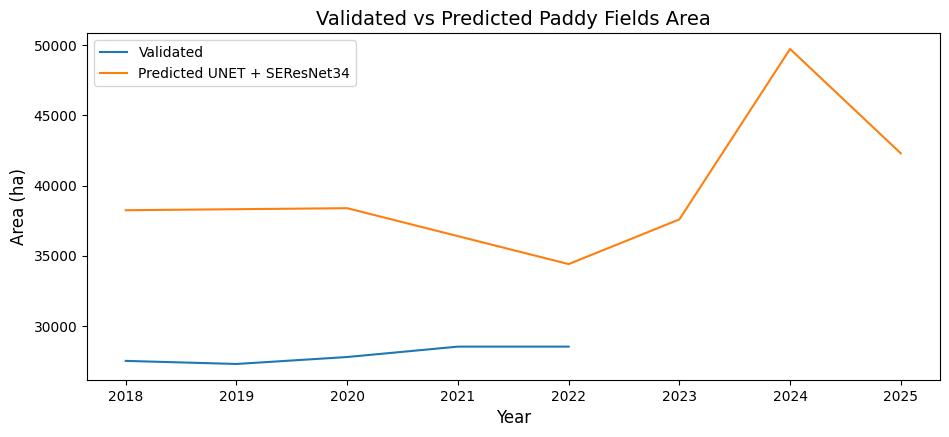

In [65]:
# PLOT VALIDATED DATA AND PREDICTIONS BY YEAR

fig, axes = plt.subplots(figsize=(11, 4.5))

# Plot validated data
axes.plot(np.array(range(2018, 2023)), np.array(list_pf_ha), label = "Validated")

# Plot predictions
axes.plot(np.array(list_year_pred), np.array(list_pfpred_ha), label = "Predicted UNET + SEResNet34")

axes.legend()
axes.set_title("Validated vs Predicted Paddy Fields Area", fontsize = 14)
axes.set_xlabel("Year", fontsize = 12)
axes.set_ylabel("Area (ha)", fontsize = 12)


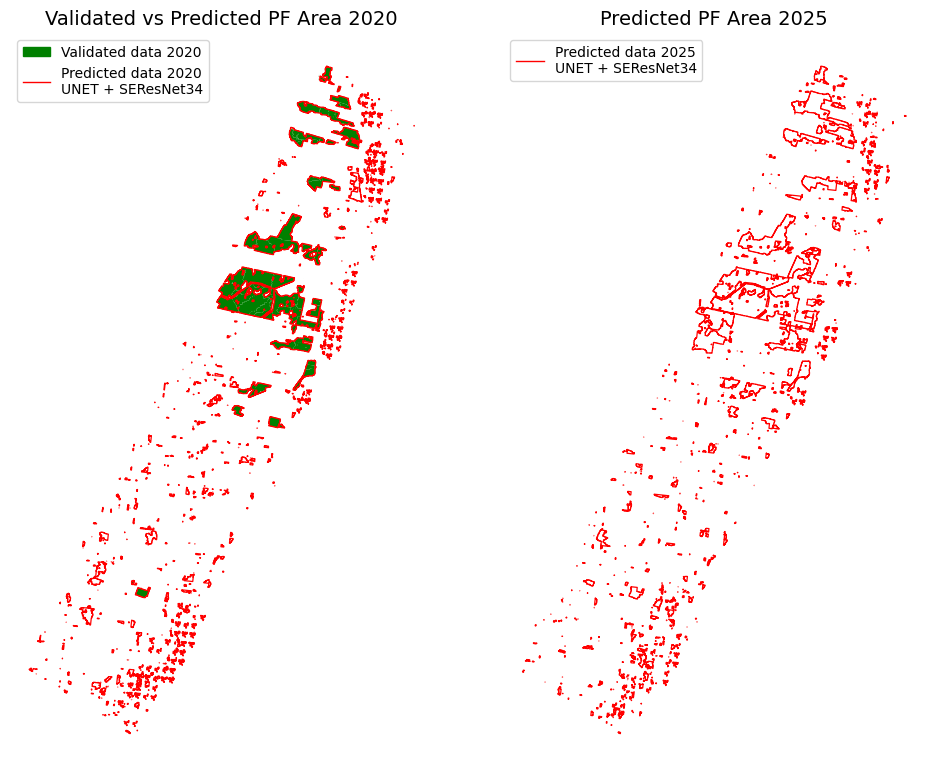

In [68]:
# PLOT VALIDATED DATA AND PREDICTIONS IN MAP FORMAT FOR TWO YEARS: ONE WHICH
# THERE WAS DATA FOR COMPARING (VAL VS PRED), AND ANOTHER WITH NO PREVIOUS DATA

# Define year 1
y_comp = 2020

# Get validated data and filter for year 1
val_ycomp =  gdf_val_pf[(gdf_val_pf['anio_ini'] <= y_comp) & (gdf_val_pf['anio_fin'] > y_comp)].copy()

# Get paddy fields area predictions for year 1
pred_ycomp = gpd.read_file(f"/content/predicts_vectorized/Predicts/vector_predict_{y_comp}.geojson").to_crs(targetCRS_meters)

# Define year 2
y_notval = 2025

# Get paddy fields area predictions for year 2
pred_ynotval = gpd.read_file(f"/content/predicts_vectorized/Predicts/vector_predict_{y_notval}.geojson").to_crs(targetCRS_meters)


# Plot results
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

# Left panel: validated + predicted
val_ycomp.plot(ax=axes[0], color="green")
pred_ycomp.plot( ax=axes[0], color="none", edgecolor="red", linewidth=0.9
)

legend_left = [
    Patch(facecolor="green", edgecolor="green", label=f"Validated data {y_comp}"),
    Line2D([0], [0], color="red", lw=1, label=f"Predicted data {y_comp}\nUNET + SEResNet34")
]

axes[0].set_title(f"Validated vs Predicted PF Area {y_comp}", fontsize=14)
axes[0].axis("off")
axes[0].legend(handles=legend_left, loc="upper left")

# Right panel: predicted data
pred_ynotval.plot(ax=axes[1], color="none", edgecolor="red", linewidth=0.9)

legend_right = [
    Line2D([0], [0], color="red", lw=1, label=f"Predicted data {y_notval}\nUNET + SEResNet34")
]

axes[1].set_title(f"Predicted PF Area {y_notval}", fontsize=14)
axes[1].axis("off")
axes[1].legend(handles=legend_right, loc="upper left")

plt.tight_layout()


# Final Thoughts